In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [128]:
#--------------------Naive Bayes Classifier-----------------------------------

# loading data into pandas dataframe
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
test_results = pd.read_csv("gender_submission.csv")

# preprocessing

# dropping columns with mixed, irrelevant and less data 
train_data = train_data.drop("Cabin", axis=1)
train_data = train_data.drop("Name", axis=1)
train_data = train_data.drop("Ticket", axis=1)
train_data = train_data.drop("Age", axis=1)
train_data = train_data.drop("Fare", axis=1)

# removing null rows
train_data = train_data.dropna(how='any',axis=0)  

print(train_data)

     PassengerId  Survived  Pclass     Sex  SibSp  Parch Embarked
0              1         0       3    male      1      0        S
1              2         1       1  female      1      0        C
2              3         1       3  female      0      0        S
3              4         1       1  female      1      0        S
4              5         0       3    male      0      0        S
..           ...       ...     ...     ...    ...    ...      ...
886          887         0       2    male      0      0        S
887          888         1       1  female      0      0        S
888          889         0       3  female      1      2        S
889          890         1       1    male      0      0        C
890          891         0       3    male      0      0        Q

[889 rows x 7 columns]


In [129]:
# this function is used to group passenger id under different class 
# features
def group_into_class(df, column_name):
    grouped = df.groupby(['PassengerId', column_name])
    classified_dict = {}
    for i,j in grouped: classified_dict[i[1]] = []
    for i,j in grouped: classified_dict[i[1]].append(i[0])
    return classified_dict


In [130]:
# this function is used to calculate probabilities using bayes theorem
def get_probabilities(df, feature_name, survived, probability_survived, 
                      total_survived, total_count):
    count = 0
    probabilities = {}
    for i,j in group_into_class(df, feature_name).items():
        for k in j:
            if k in survived[1] : count = count + 1
        probabilities[i] = ((count/total_survived)*
                                probability_survived)/(len(j)/total_count)
        count = 0
    return probabilities

In [131]:
# this function is used to predict the output based on the probabilities 
def predict_naive_bayes(df, feature_names, probability_weights):
    new_dict = {}

    for f in feature_names:
      for i,j in group_into_class(df, f).items():
        for k in j:
          p = probability_weights[f][i]
          if k not in new_dict.keys(): new_dict[k] = 0
          new_dict[k] = new_dict[k] + p

    for i, j in new_dict.items():
      new_dict[i] = 1 if (j/len(feature_names) > 1 - j/len(feature_names)) else 0

    return new_dict

In [132]:
# this function is used to give % accuracy of the model
def calculate_accuracy(output_dict, df):
    accuracy = 0
    df_dict = {}
    for i,j in zip(df['PassengerId'].values, df['Survived'].values):
      df_dict[i] = j
    for i,j in output_dict.items():
      if output_dict[i] == df_dict[i]: accuracy = accuracy + 1
    return str((accuracy/len(output_dict.values())*100))

In [133]:
# ---------------------------Main (Naive Bayes)------------------------------
if __name__ == "__main__":

  survived = group_into_class(train_data, 'Survived')
  total_survived = len(survived[1])
  total_count = len(survived[0]) + len(survived[1])
  probability_survived = total_survived/total_count

  # using only Sex column 

  gender_probability_weights = get_probabilities(train_data, "Sex", survived, 
                    probability_survived, total_survived, total_count)
  
  prediction_on_test_data =  predict_naive_bayes(test_data, ["Sex"],
                                          {"Sex": gender_probability_weights})
  
  print("Accuracy of prediction on test data using only sex - ", 
                    calculate_accuracy(prediction_on_test_data, test_results))

  # using sex and sibsp column 

  sibsp_probability_weights = get_probabilities(train_data, "SibSp", survived, 
                    probability_survived, total_survived, total_count)
  
  prediction_on_test_data =  predict_naive_bayes(test_data, ["Sex", "SibSp"],
      {"Sex": gender_probability_weights, "SibSp": sibsp_probability_weights})

  print("Accuracy of prediction on test data using SibSp and Sex - ", 
                    calculate_accuracy(prediction_on_test_data, test_results))
    
  print("\nEnd of naive bayes")
  print("-----------------------------------------------------------------")

Accuracy of prediction on test data using only sex -  100.0
Accuracy of prediction on test data using SibSp and Sex -  99.04306220095694

End of naive bayes
-----------------------------------------------------------------


     PassengerId  Survived   Age     Fare
0              1         0  22.0   7.2500
1              2         1  38.0  71.2833
2              3         1  26.0   7.9250
3              4         1  35.0  53.1000
4              5         0  35.0   8.0500
..           ...       ...   ...      ...
885          886         0  39.0  29.1250
886          887         0  27.0  13.0000
887          888         1  19.0  30.0000
889          890         1  26.0  30.0000
890          891         0  32.0   7.7500

[711 rows x 4 columns]


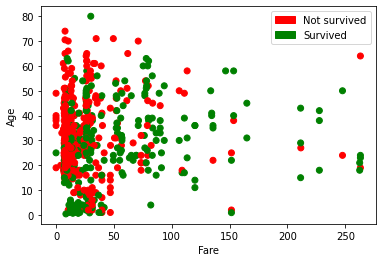

In [134]:
#--------------------KNN Classifier-----------------------------------

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
test_results = pd.read_csv("gender_submission.csv")

# preprocessing

# dropping columns with mixed, irrelevant and less data points
train_data = train_data.drop("Cabin", axis=1)
train_data = train_data.drop("Name", axis=1)
train_data = train_data.drop("Ticket", axis=1)
train_data = train_data.drop("SibSp", axis=1)
train_data = train_data.drop("Parch", axis=1)
train_data = train_data.drop("Embarked", axis=1)
train_data = train_data.drop("Pclass", axis=1)
train_data = train_data.drop("Sex", axis=1)

# removing null and sparse data points
train_data = train_data.dropna(how='any',axis=0) 
train_data.drop(train_data[train_data["Fare"]>300].index, inplace=True)

print(train_data)

# using age and fare for this model
colormap = np.array(['r', 'g'])
x = train_data['Fare'].tolist()
y = train_data['Age'].tolist()
plt.scatter(x, y, c=colormap[train_data['Survived'].to_numpy()])
plt.xlabel("Fare")
plt.ylabel("Age")
red = mpatches.Patch(color='red', label='Not survived')
green = mpatches.Patch(color='green', label='Survived')
plt.legend(handles=[red,green])


In [135]:
# this function is used to calculate euclidean distance
def euclid_dist(x1, y1, x2, y2):  
  return ((x2-x1)**2 + (y2-y1)**2)**0.5

In [136]:
# this function is used to get the data points for survived and not survived
def data_points(train_data):
  new_dict = {}
  for x,y,p in zip(train_data["Fare"].to_list(), train_data["Age"].to_list(), 
                   train_data["Survived"].to_list()):
    if p not in new_dict.keys(): new_dict[p] = [(x,y)]
    else : new_dict[p].append((x,y))
  return new_dict

In [137]:
# this function is used to predict the output using knn method
def predict_knn(data, test_data, threshold):
  prediction = {}
  dists = []
  for x,y,id in zip(test_data["Fare"].to_list(), test_data["Age"].to_list(), 
                   test_data["PassengerId"].to_list()):
    # calculate distance of test data point with trained data points
    for i,j in data.items():
      for k in j:
        dist = euclid_dist(k[0], k[1], x, y)
        if dist <= threshold: dists.append(dist)
      if i == 1: survived_dists = dists
      else : not_survived_dists = dists
      dists = []
    # if many data points are closer to survived then prediction is 1 else 0
    if len(survived_dists)>len(not_survived_dists): p = 1
    else : p = 0
    prediction[id] = p
  return prediction

In [138]:
# -------------------------------Main knn--------------------------------
if __name__ == "__main__":
  data_point_weights = data_points(train_data)
  # using 30 as threshold distance 
  predictions = predict_knn(data_point_weights, test_data, 30)
  accuracy = calculate_accuracy(preds, test_results)
  print("The accuracy of the knn model on test data - ", accuracy)
  print("\n-------------------End of Knn classifier-----------------------")

The accuracy of the knn model on test data -  65.78947368421053

-------------------End of Knn classifier-----------------------
